In [20]:
from tqdm import trange
from algs_one_mtx import CBSCFD, LinUCBwithPSI_rank1, LinUCB_SM, CBRAP
from models.dbsl import DBSL

from env_mnist import *

In [13]:
images, labels = load_mnist("datasets/MNIST/raw")
features = images / np.max(np.linalg.norm(images, axis=1))
clusters = group_by_class(features, labels)

print(features.shape)
print([(clusters[k].shape) for k in range(10)])

(60000, 784)
[(5923, 784), (6742, 784), (5958, 784), (6131, 784), (5842, 784), (5421, 784), (5918, 784), (6265, 784), (5851, 784), (5949, 784)]


Run 1/1


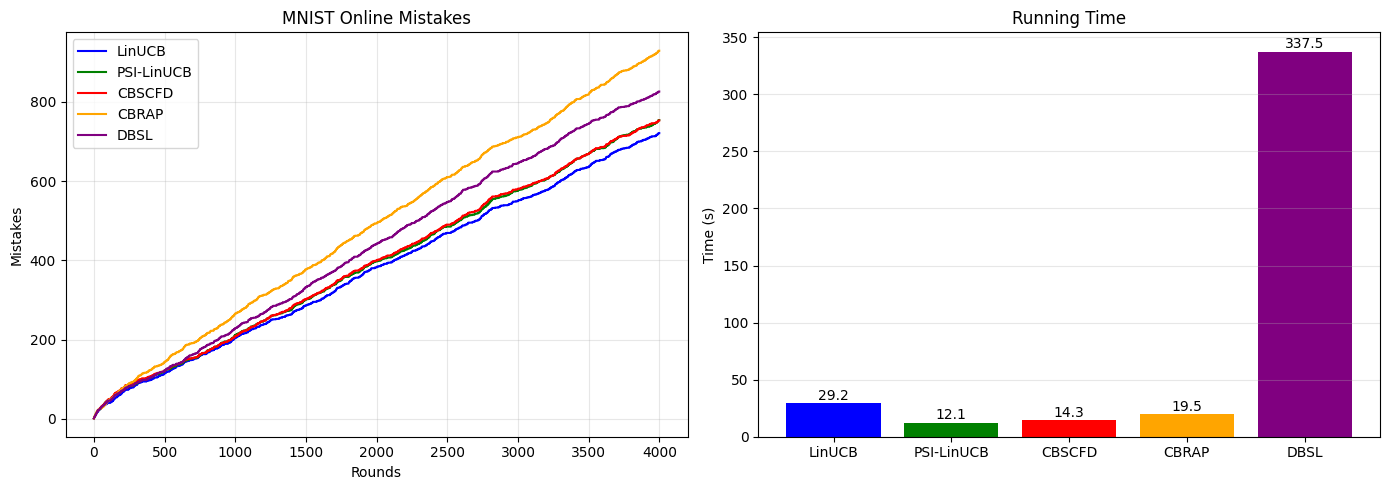


Final Results:
LinUCB: Mistakes=721.0, Time=29.2s
PSI-LinUCB: Mistakes=754.0, Time=12.1s
CBSCFD: Mistakes=753.0, Time=14.3s
CBRAP: Mistakes=929.0, Time=19.5s
DBSL: Mistakes=826.0, Time=337.5s


In [53]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import time

T = 4000
n_runs = 1
d = 784
num_arms = 10

# LinUCB
alpha_lin = 0.0001
epsilon_lin = 0.2

# PSI-LinUCB
alpha_psi = 0.1
epsilon_psi = 1
rank_psi = 90

# CBSCFD
beta_cbscfd = 0.1
lambd_cbscfd = 0.2
m_cbscfd = 100

# CBRAP
beta_cbrap = 0.0001
lambd_cbrap = 0.2
m_cbrap = 90

# DBSL
beta_dbsl = 0.001
lambd_dbsl = 0.2
sketch_dbsl = 50
eps_dbsl = 8

results = {name: [] for name in ['LinUCB', 'PSI-LinUCB', 'CBSCFD', 'CBRAP', 'DBSL']}
times = {name: [] for name in ['LinUCB', 'PSI-LinUCB', 'CBSCFD', 'CBRAP', 'DBSL']}

for run in range(n_runs):
    print(f"Run {run+1}/{n_runs}")
    np.random.seed(run)

    linucb = LinUCB_SM(d, alpha_lin, epsilon_lin)
    psi = LinUCBwithPSI_rank1(d, epsilon_psi, alpha_psi, rank_psi)
    cbscfd = CBSCFD(lambd_cbscfd, beta_cbscfd, m_cbscfd, d)
    cbrap = CBRAP(d, lambd_cbrap, beta_cbrap, m_cbrap)
    dbsl = DBSL(d, sketch_size=sketch_dbsl, eps=eps_dbsl, beta=beta_dbsl, lmd=lambd_dbsl, robust=True)

    env_linucb = MNISTBanditEnv(clusters, target_class=8)
    env_psi = MNISTBanditEnv(clusters, target_class=8)
    env_cbscfd = MNISTBanditEnv(clusters, target_class=8)
    env_cbrap = MNISTBanditEnv(clusters, target_class=8)
    env_dbsl = MNISTBanditEnv(clusters, target_class=8)

    time_linucb, time_psi, time_cbscfd, time_cbrap, time_dbsl = 0, 0, 0, 0, 0

    for t in trange(T, leave=False):
        np.random.seed(run * T + t)
        contexts = env_linucb.get_contexts()

        # LinUCB
        t0 = time.perf_counter()
        action = int(np.argmax([linucb.score(contexts[a]) for a in range(num_arms)]))
        reward = env_linucb.step(action)
        linucb.update(contexts[action], reward)
        time_linucb += time.perf_counter() - t0

        # PSI-LinUCB
        t0 = time.perf_counter()
        action = int(np.argmax([psi.score(contexts[a]) for a in range(num_arms)]))
        reward = env_psi.step(action)
        psi.update(contexts[action], reward)
        time_psi += time.perf_counter() - t0

        # CBSCFD
        t0 = time.perf_counter()
        action = cbscfd.select_arm(contexts)
        reward = env_cbscfd.step(action)
        cbscfd.update(contexts[action], reward)
        time_cbscfd += time.perf_counter() - t0

        # CBRAP
        t0 = time.perf_counter()
        action = int(np.argmax([cbrap.score(contexts[a]) for a in range(num_arms)]))
        reward = env_cbrap.step(action)
        cbrap.update(contexts[action], reward)
        time_cbrap += time.perf_counter() - t0

        # DBSL
        t0 = time.perf_counter()
        def observe(ind, x): return env_dbsl.step(ind)
        dbsl.fit(contexts, observe)
        time_dbsl += time.perf_counter() - t0

    results['LinUCB'].append(env_linucb.cumulative_mistakes)
    results['PSI-LinUCB'].append(env_psi.cumulative_mistakes)
    results['CBSCFD'].append(env_cbscfd.cumulative_mistakes)
    results['CBRAP'].append(env_cbrap.cumulative_mistakes)
    results['DBSL'].append(env_dbsl.cumulative_mistakes)

    times['LinUCB'].append(time_linucb)
    times['PSI-LinUCB'].append(time_psi)
    times['CBSCFD'].append(time_cbscfd)
    times['CBRAP'].append(time_cbrap)
    times['DBSL'].append(time_dbsl)

# Графики
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График ошибок
ax = axes[0]
colors = {'LinUCB': 'blue', 'PSI-LinUCB': 'green', 'CBSCFD': 'red', 'CBRAP': 'orange', 'DBSL': 'purple'}
for name in results:
    arr = np.array(results[name])
    mean = np.mean(arr, axis=0)
    ax.plot(mean, label=name, color=colors[name])
ax.set_xlabel('Rounds')
ax.set_ylabel('Mistakes')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_title('MNIST Online Mistakes')

# График времени (столбчатый)
ax = axes[1]
names = list(times.keys())
mean_times = [np.mean(times[name]) for name in names]
bars = ax.bar(names, mean_times, color=[colors[name] for name in names])
ax.set_ylabel('Time (s)')
ax.set_title('Running Time')
ax.grid(True, alpha=0.3, axis='y')

for bar, t in zip(bars, mean_times):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{t:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Результаты
print("\nFinal Results:")
for name in results:
    arr = np.array(results[name])
    print(f"{name}: Mistakes={np.mean(arr[:,-1]):.1f}, Time={np.mean(times[name]):.1f}s")